Instructions
-------------
This notebook borrows heavily from the notebook provided by Krzysztof Chalupka and colleagues as a supplement to their UAI 2016 paper "Unsupervised Discovery of El Nino Using Causal Feature Learning on Micro-Level Climate Data". Here, it implements the Algorithm 2 from our paper "Pragamatic Causal Feature Learning".

At the end, you should get a "Westerly Winds" and "El Nino" cluster, and see that they correlate strongly in the conditional probability table. 

In [1]:
""" This cell sets up the Python environment. Make sure you have the following packages installed:
numpy
matplotlib
theano
lasagne
sklearn
All of them are available through $ pip install [package_name]. 
This is only tested on Ubuntu Linux, I've heard Theano is a pain to get working on Windows.
"""

import sys

import numpy as np
np.random.seed(1423)
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import theano
import lasagne

sys.setrecursionlimit(1000000) # Otherwise, joblib won't save deep nets.
imshape = (55, 9) # This is the grid shape of our images, stored here for plotting reference.

The Dataset
-----------

The following code loads our data into the correct format:
* X -- numpy array of size (n_datapoints, n_input_dim). Each row corresponds to one input value.
* Y -- numpy array of size (n_datapoints, n_output_dim). Each row is one output value.

In our case, each row of X is a (flattened) map of Pacific zonal wind strength, and each row of Y a (flattened) map of Pacific water temperature over the same region. In our case, n_input_dim == n_output_dim, but this need not be the case at all.

In [2]:
import joblib 

# Load the data. 
## PLUG YOUR OWN DATA HERE. 'coords' is only needed to display climate maps. Your data
## can only contain X and Y arrays.
X, Y, coords = joblib.load('elnino_data.pkl')

/Users/davidkinney/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The file 'elnino_data.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  


The Utility Function
---------------------

Tranform the Y values so that they are utilities, as defined by the utility function given in our paper, and then create the training and validation sets using these transformed Y values. 

In [3]:
Y = ((1/np.sqrt(.02*3.14))*np.exp(-(np.round(Y,1)-26)**2/.02))-1

# Create a randomized, normalized training and validation set.
shuffled_ids = np.random.permutation(X.shape[0])
X_tr = X[shuffled_ids[:int(X.shape[0]*.9)]]
Y_tr = Y[shuffled_ids[:int(Y.shape[0]*.9)]]
X_ts = X[shuffled_ids[int(X.shape[0]*.9):]]
Y_ts = Y[shuffled_ids[int(Y.shape[0]*.9):]]
x_scaler = StandardScaler().fit(X_tr)
y_scaler = StandardScaler().fit(Y_tr)
X_tr = x_scaler.transform(X_tr)
X_ts = x_scaler.transform(X_ts)
Y_tr = y_scaler.transform(Y_tr)
Y_ts = y_scaler.transform(Y_ts)

Learning E(u(x,Y) | x))
-----------------------

The first step of Pragmatic Causal Feature Learning (CFL) is to cluster x's according to the expected value E(u(x,Y) | x)). Learning E(u(x,Y) | x)) amounts to regressing u(x,y) on x. We do this using a neural network and the Lasagne package. Be sure to train the network until it converges. 

In [4]:
# Define the network architecture.
dropout = lasagne.layers.dropout
batch_norm = lasagne.layers.batch_norm

net = lasagne.layers.InputLayer(shape=(None, X[0].size))
net = dropout(net, p=.2)
net = lasagne.layers.DenseLayer(net, num_units=1024, W=lasagne.init.HeNormal(gain=1))
net = dropout(net, p=.5)
net = lasagne.layers.DenseLayer(net, num_units=1024, W=lasagne.init.HeNormal(gain=1))
net = dropout(net, p=.5)
net = lasagne.layers.DenseLayer(net, num_units=Y[0].size,
    nonlinearity=lasagne.nonlinearities.identity)

# Define the cost function in Theano.
input_var = lasagne.layers.get_all_layers(net)[0].input_var
target_var = theano.tensor.matrix('target')
train_cost = lasagne.objectives.squared_error(lasagne.layers.get_output(net), target_var).mean() +\
    0.0001 * lasagne.regularization.regularize_network_params(net, lasagne.regularization.l2)
valid_cost = lasagne.objectives.squared_error(
    lasagne.layers.get_output(net, deterministic=True), target_var).mean()

# Compile the training algorithm in Lasagne.
parameters = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(train_cost, parameters, learning_rate=1e-4)
train = theano.function([input_var, target_var], 
    train_cost, updates=updates, allow_input_downcast=True)
valid = theano.function([input_var, target_var], valid_cost, allow_input_downcast=True)

# Train. 
BATCHSIZE = 128
val_loss = valid(X_ts, Y_ts)
print('Validation mse before training: {:.2g}.'.format(float(val_loss)))
best_loss = np.inf
for epoch_id in range(1000):
    tr_loss = 0
    for batch_id in range(int(np.floor(X_tr.shape[1]/BATCHSIZE))):
        tr_loss += train(X_tr[batch_id*BATCHSIZE:(batch_id+1)*BATCHSIZE],
                         Y_tr[batch_id*BATCHSIZE:(batch_id+1)*BATCHSIZE])
    val_loss = valid(X_ts, Y_ts)

    if np.isfinite(val_loss) and val_loss < best_loss:
        joblib.dump(net, 'nn_params/nn.pkl')
        best_loss = val_loss

    sys.stdout.write('\rEpoch {}. Valid loss {:.4g} [best {:.4g}]. Train loss {:.4g}.'.format(
            epoch_id, float(val_loss), float(best_loss), tr_loss/float(np.floor(X_tr.shape[1]/BATCHSIZE))))
    sys.stdout.flush()
print('Done')

Validation mse before training: 1.3.
Epoch 361. Valid loss 0.9136 [best 0.9136]. Train loss 1.034.

KeyboardInterrupt: 

Finding the Observational Partition of X
-----------------------------------------
Finding the observational partition of X amounts to clustering the X data according to E[u(x,Y) | x)]. That is, we put two x's in the same bucket if the neural net we trained maps them to the same values.

In [5]:
# Load the best network found and compile it.
net = joblib.load('nn_params/nn.pkl')
input_var = lasagne.layers.get_all_layers(net)[0].input_var
p_y_x = theano.function([input_var], lasagne.layers.get_output(net))

# Cluster Xs.
N_CLASSES = 4
x_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(p_y_x(np.vstack([X_tr, X_ts])))

Finding the Observational Partition of Y
---------------------------------------------
To find the partition of Y, we want to put together all y1 and y2 if u(x,y1) == u(x,y1) for all x. Unlike in Chalupka et al.'s algorithm, in our algorithm this is very straightforward.

In [6]:
y_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(np.vstack([Y_tr,Y_ts]))

Understanding the Results
--------------------------
Visualizing the observational partition is data-specific. In our case, since both X and Y are images, we can visualize the means of each observational cluster to gain some insight into what it contains. 

But, one of the virtues of the method is that it is interpretation-agnostic. The observational partition can be used as a causal hypothesis to drive experimentation. This can be done whether the inputs and outputs are easily interpretable or not at all.

P(TempCluster | WindCluster):
[[0.02538787 0.32299013 0.64927127 0.00235073]
 [0.08636017 0.8020066  0.10312421 0.00850902]
 [0.62748926 0.25888325 0.08199922 0.03162827]
 [0.12975779 0.35813149 0.05882353 0.4532872 ]]


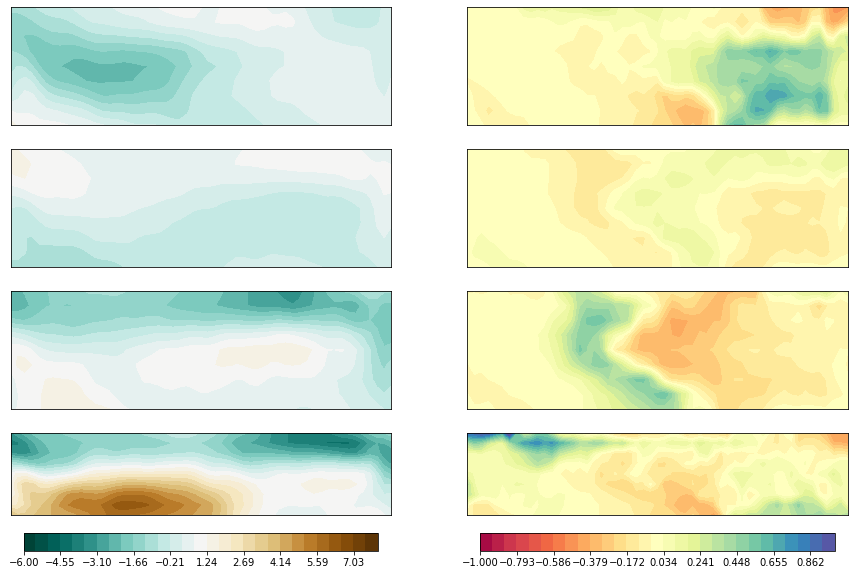

In [61]:
fig = plt.figure(figsize=(15,10), facecolor='white')
X_raw = x_scaler.inverse_transform(np.vstack([X_tr, X_ts]))
Y_raw = y_scaler.inverse_transform(np.vstack([Y_tr, Y_ts]))

levels = np.linspace(-6,8,30)
x_cluster_id=0
ax = plt.subplot2grid((4,2), (x_cluster_id, 0))  
cluster_mean = (X_raw[x_lbls==x_cluster_id].mean(axis=0)-X_raw.mean(axis=0)).reshape(imshape).T
imx1=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='BrBG_r')
ax.set_xticks([]); ax.set_yticks([])

levels = np.linspace(-6,8,30)
x_cluster_id=1
ax = plt.subplot2grid((4,2), (x_cluster_id, 0))  
cluster_mean = (X_raw[x_lbls==x_cluster_id].mean(axis=0)-X_raw.mean(axis=0)).reshape(imshape).T
im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='BrBG_r')
ax.set_xticks([]); ax.set_yticks([])

levels = np.linspace(-6,8,30)
x_cluster_id=2
ax = plt.subplot2grid((4,2), (x_cluster_id, 0))  
cluster_mean = (X_raw[x_lbls==x_cluster_id].mean(axis=0)-X_raw.mean(axis=0)).reshape(imshape).T
im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='BrBG_r')
ax.set_xticks([]); ax.set_yticks([])

levels = np.linspace(-6,8,30)
x_cluster_id=3
ax = plt.subplot2grid((4,2), (x_cluster_id, 0))  
cluster_mean = (X_raw[x_lbls==x_cluster_id].mean(axis=0)-X_raw.mean(axis=0)).reshape(imshape).T
im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='BrBG_r')
ax.set_xticks([]); ax.set_yticks([])

fig.colorbar(im,orientation='horizontal')

levels=np.linspace(-1,1,30)
y_cluster_id=0
ax = plt.subplot2grid((4,2), (y_cluster_id, 1))  
# Plot the cluster's mean difference from all frames' mean.
cluster_mean = (Y_raw[y_lbls==y_cluster_id].mean(axis=0)-Y_raw.mean(axis=0)).reshape(imshape).T
im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='Spectral')
ax.set_xticks([]); ax.set_yticks([])


levels=np.linspace(-1,1,30)
y_cluster_id=1
ax = plt.subplot2grid((4,2), (y_cluster_id, 1))  
# Plot the cluster's mean difference from all frames' mean.
cluster_mean = (Y_raw[y_lbls==y_cluster_id].mean(axis=0)-Y_raw.mean(axis=0)).reshape(imshape).T
im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='Spectral')
ax.set_xticks([]); ax.set_yticks([])

levels=np.linspace(-1,1,30)
y_cluster_id=2
ax = plt.subplot2grid((4,2), (y_cluster_id, 1))  
# Plot the cluster's mean difference from all frames' mean.
cluster_mean = (Y_raw[y_lbls==y_cluster_id].mean(axis=0)-Y_raw.mean(axis=0)).reshape(imshape).T
im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='Spectral')
ax.set_xticks([]); ax.set_yticks([])
    
    
levels=np.linspace(-1,1,30)
y_cluster_id=3
ax = plt.subplot2grid((4,2), (y_cluster_id, 1))  
# Plot the cluster's mean difference from all frames' mean.
cluster_mean = (Y_raw[y_lbls==y_cluster_id].mean(axis=0)-Y_raw.mean(axis=0)).reshape(imshape).T
im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='Spectral')
ax.set_xticks([]); ax.set_yticks([])

fig.colorbar(im,orientation='horizontal')

    
# Compute and print P(y_lbl | x_lbl)
P_CE = np.array([np.bincount(y_lbls.astype(int)[x_lbls==x_lbl], 
    minlength=y_lbls.max()+1).astype(float) for x_lbl in np.sort(np.unique(x_lbls))])
P_CE = P_CE/P_CE.sum()
P_E_given_C = P_CE/P_CE.sum(axis=1, keepdims=True)

print('P(TempCluster | WindCluster):')
print(P_E_given_C)